<a href="https://colab.research.google.com/github/fertorresfs/avanti_machine_learning/blob/main/ATIV-04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1. Importação de Bibliotecas e Setup

In [ ]:
# Importando bibliotecas essenciais
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# Configurando a API do Kaggle para baixar o dataset
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Baixando o dataset
!kaggle datasets download -d alistairking/recyclable-and-household-waste-classification
# Descompacta o arquivo baixado
with zipfile.ZipFile("recyclable-and-household-waste-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("kaggle")

print('Data source import complete.')

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
recyclable-and-household-waste-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Data source import complete.


###2. Pré-processamento e Análise do Dataset

Category: styrofoam_cups, Total Image Count: 500
Category: plastic_food_containers, Total Image Count: 500
Category: newspaper, Total Image Count: 500
Category: plastic_water_bottles, Total Image Count: 500
Category: cardboard_boxes, Total Image Count: 500
Category: food_waste, Total Image Count: 500
Category: eggshells, Total Image Count: 500
Category: coffee_grounds, Total Image Count: 500
Category: glass_food_jars, Total Image Count: 500
Category: magazines, Total Image Count: 500
Category: aluminum_food_cans, Total Image Count: 500
Category: plastic_detergent_bottles, Total Image Count: 500
Category: plastic_shopping_bags, Total Image Count: 500
Category: paper_cups, Total Image Count: 500
Category: plastic_soda_bottles, Total Image Count: 500
Category: office_paper, Total Image Count: 500
Category: glass_beverage_bottles, Total Image Count: 500
Category: styrofoam_food_containers, Total Image Count: 500
Category: shoes, Total Image Count: 500
Category: plastic_trash_bags, Total Im

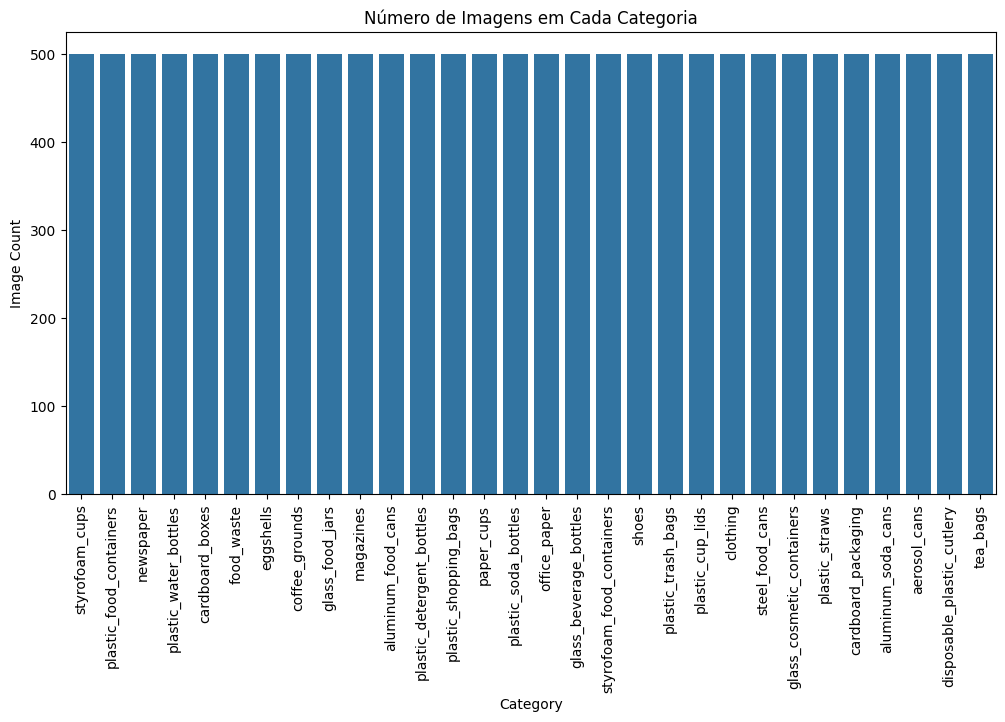

In [ ]:
# Diretório do dataset
train_dir = '/content/kaggle/images/images'

# Função para contar as imagens em cada categoria
def contar_imagens_por_categoria(train_dir):
  data = {'Category': [], 'Image Count': []}
  for class_dir in os.listdir(train_dir):
      class_dir_path = os.path.join(train_dir, class_dir)
      if os.path.isdir(class_dir_path):
          total_images = 0
          for sub_dir in ['default', 'real_world']:
              sub_dir_path = os.path.join(class_dir_path, sub_dir)
              if os.path.isdir(sub_dir_path):
                  num_files = len([f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])
                  total_images += num_files
          data['Category'].append(class_dir)
          data['Image Count'].append(total_images)
          print(f"Category: {class_dir}, Total Image Count: {total_images}")
  return data

# Analisando o dataset e criando gráfico
data = contar_imagens_por_categoria(train_dir)
df = pd.DataFrame(data)
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Image Count', data=df)
plt.xticks(rotation=90)
plt.title('Número de Imagens em Cada Categoria')
plt.ylabel('Image Count')
plt.xlabel('Category')
plt.show()

# Definindo o tamanho das imagens e o batch size
img_size = (224, 224, 3)
batch_size = 8

# Lista de classes
class_names = [
    "aerosol_cans",
    "steel_food_cans",
    "plastic_soda_bottles",
    "disposable_plastic_cutlery",
    "cardboard_boxes",
    "glass_beverage_bottles"
]

# Função para coletar caminhos das imagens e labels
def collect_image_paths_and_labels(base_dir, class_names):
  image_paths = []
  labels = []
  for label, class_name in enumerate(class_names):
      class_dir = os.path.join(base_dir, class_name)
      if os.path.isdir(class_dir):
          for sub_dir in ['default', 'real_world']:
              sub_dir_path = os.path.join(class_dir, sub_dir)
              if os.path.isdir(sub_dir_path):
                  for file_name in os.listdir(sub_dir_path):
                      file_path = os.path.join(sub_dir_path, file_name)
                      if os.path.isfile(file_path):
                          image_paths.append(file_path)
                          labels.append(label)
  return image_paths, labels

# Coletando paths e labels
image_paths, labels = collect_image_paths_and_labels(train_dir, class_names)

# Convertendo para TensorFlow Dataset
image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
labels_ds = tf.data.Dataset.from_tensor_slices(tf.one_hot(labels, depth=len(class_names)))

# Função para carregar e pré-processar imagens
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224)) #img_size = 224,224
    image = image / 255.0
    return image

# Aplicando a função load_image ao dataset
image_ds = image_paths_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Combinando datasets de imagens e labels
dataset = tf.data.Dataset.zip((image_ds, labels_ds))

# Embaralhando o dataset
dataset = dataset.shuffle(buffer_size=len(image_paths))

# Dividindo o dataset
test_size = int(0.1 * len(image_paths))
val_size = int(0.1 * len(image_paths))
train_size = len(image_paths) - test_size - val_size

train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)

validation_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

# Batch e prefetch para melhor desempenho
#AUTOTUNE = tf.data.experimental.AUTOTUNE
#train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)
#validation_dataset = validation_dataset.batch(batch_size).prefetch(AUTOTUNE)
#test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

###3. Criação e Treinamento do Modelo

In [ ]:
# Definindo a função para construir o ResNet50
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters * 4, kernel_size=1, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet50(input_shape=img_size, num_classes=6): #(224, 224, 3)
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

# Criando o modelo
model = build_resnet50(input_shape=img_size)
#model = build_resnet50(input_shape=(224, 224, 3)) # Corrigindo o input_shape

# Compilando o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Definindo o callback para salvar o melhor modelo
checkpoint_cb = ModelCheckpoint(filepath='custom_best_without_early.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max',
                                verbose=1)

# Treinando o modelo
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2616 - loss: 2.5951
Epoch 1: val_accuracy improved from -inf to 0.20333, saving model to custom_best_without_early.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 100s 138ms/step - accuracy: 0.2618 - loss: 2.5932 - val_accuracy: 0.2033 - val_loss: 7.4157
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3827 - loss: 1.6759
Epoch 2: val_accuracy did not improve from 0.20333
300/300 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - accuracy: 0.3827 - loss: 1.6757 - val_accuracy: 0.1500 - val_loss: 3.9605
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4154 - loss: 1.5165
Epoch 3: val_accuracy improved from 0.20333 to 0.21333, saving model to custom_best_without_early.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 59s 175ms/step - accuracy: 0.4155 - loss: 1.5164 - val_accuracy: 0.2133 - val_loss: 2.6961
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4728 - loss: 1.3719
Epoch 4: val_accuracy improved from 0.2

###4. Transfer Learning

In [ ]:
from tensorflow.keras.applications import ResNet50

# Carregando o ResNet50 pré-treinado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size)

# Adicionando camadas para a classificação
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
output_layer = layers.Dense(len(class_names), activation='softmax')(x)

# Criando o modelo final
model = models.Model(inputs=base_model.input, outputs=output_layer)

# Descongelando as últimas camadas para fine-tuning
base_model.trainable = True
fine_tune_at = 110
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilando o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning
fine_tune_110_onwards_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[checkpoint_cb]
)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3314 - loss: 1.6127
Epoch 1: val_accuracy improved from 0.28000 to 0.46667, saving model to custom_best_without_early.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - accuracy: 0.3316 - loss: 1.6123 - val_accuracy: 0.4667 - val_loss: 1.4588
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6079 - loss: 1.1453
Epoch 2: val_accuracy improved from 0.46667 to 0.62000, saving model to custom_best_without_early.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 118ms/step - accuracy: 0.6080 - loss: 1.1451 - val_accuracy: 0.6200 - val_loss: 1.0295
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6888 - loss: 0.8949
Epoch 3: val_accuracy improved from 0.62000 to 0.71333, saving model to custom_best_without_early.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 104s 198ms/step - accuracy: 0.6888 - loss: 0.8949 - val_accuracy: 0.7133 - val_loss: 0.7664
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.761

###5. Avaliação do Modelo

In [ ]:
# Avaliando o modelo
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8492 - loss: 0.4502
Test Loss: 0.4695
Test Accuracy: 0.8467


###6. Predição e Implementação (Testando)

In [ ]:
# Função para fazer predições
def predir_lixo(imagem_path):
  # Carregar imagem
  image = tf.io.read_file(imagem_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, img_size[:2])
  image = image / 255.0

  # Fazer predição
  prediction = model.predict(tf.expand_dims(image, axis=0))

  # Encontrar a classe com maior probabilidade
  predicted_class = np.argmax(prediction)

  # Retornar a classe predita
  return class_names[predicted_class]

# Testando a função predir_lixo (opcional)
imagem_path = '/content/kaggle/images/images/aerosol_cans/real_world/Image_1.png'
#imagem_path = '/content/kaggle/images/prediction/imagem_predita.jpg'
classe_predita = predir_lixo(imagem_path)
print(f"A classe predita é: {classe_predita}")

# Salvar o modelo treinado (opcional)
model.save('classificador_lixo.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


A classe predita é: aerosol_cans


###7. Otimização e Melhorias (Testando)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(AUTOTUNE)